# Satatitical Analysis Between SSL Embeddings and Manual Features
---
**Author:** Weiyu Zhang

**Date:** 2025.1.28

**Description:** Predict manual features from embeddings. This script includes separate training loops for classification (water access) and regression (e.g., elevation, bioclimatic variables) tasks. The resulting models are plotted as scatter plots.

## Import dependencies and utils function

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import pandas as pd
import numpy as np
import matplotlib as mpl
from scipy import stats
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_squared_error, r2_score, roc_curve, 
                             roc_auc_score, accuracy_score, classification_report)

def show_cols(column_list):
    """
    Function to display all elements of a DataFrame columns without truncation.
    Configures pandas and NumPy to display all data without truncation and prints a list.
    
    Args:
        column_list (list-like): A list or other iterable (e.g., DataFrame.columns)
            to be printed in its entirety.
    """
    # Set NumPy to print the full array without truncation.
    np.set_printoptions(threshold=np.inf)
    # Set pandas to display all columns of a DataFrame.
    pd.set_option('display.max_columns', None)
    # Set pandas to display all rows of a DataFrame.
    pd.set_option('display.max_rows', None)
    # Set the maximum width for displaying column content.
    pd.set_option('max_colwidth', 100)
    # Print the provided list as a NumPy array.
    print(np.array(column_list))

## Dataset loading

In [ ]:
# Please replace the combined_df_path with the actual location of your combined DataFrame.
# Combined data means the parquet file containing both embeddings, manual features and city existence.
combined_df_path = "/path/to/combined_data.parquet"

combined_df = pd.read_parquet(combined_df_path)

# Define lists of column names for different feature types.
# Manually-defined geographic and bioclimatic attributes.
attr_list = [
    "mean", "std", "bio_1", "bio_4", "bio_12", "bio_15", "bio_7", 
    "bio_8", "bio_9", "bio_18", "bio_19", "d_river", "d_lake", "d_sea",
]
# Learned embeddings (columns starting with 'C' (climate emb.) or 'D' (dem-water emb.)).
embedding_list = [
    col for col in combined_df.columns if col.startswith("C") or col.startswith("D")
]

# Define columns for creating water proximity dummy variables.
water_variables = ['d_sea', 'd_river', 'd_lake', 'id']
dummy_water_variables = ['d_sea_dummy', 'd_river_dummy', 'd_lake_dummy']

# Create a new DataFrame for water-related features.
water_df = combined_df[water_variables].copy()

# Create binary dummy variables based on a distance threshold.
# A value of 1 indicates proximity (distance < 2500m), 0 otherwise.
for col in dummy_water_variables:
    original_col = col.replace('_dummy', '')
    water_df[col] = water_df[original_col].apply(lambda x: 1 if x < 2500 else 0)
    
# Reset indices to ensure they are clean and sequential
water_df.reset_index(drop=True, inplace=True)
combined_df.reset_index(drop=True, inplace=True)

## Fitting predicting models

#### Train models to predict water access

In [ ]:
# Train and store an XGBoost classifier for each specified water proximity variable.
# Define the target dummy variables to loop through.
water_types = ['d_lake_dummy', 'd_river_dummy', 'd_sea_dummy']

# Create an empty dictionary to store the trained model and its test data for each target.
models_water = {}

# Loop through each water proximity type to train a separate model.
for water_type in water_types:
    print(f"Training model for: {water_type}")
    
    # 1. Define features (X) and the current target variable (y).
    # Using .copy() is good practice to avoid pandas SettingWithCopyWarning.
    X = combined_df[embedding_list].copy()
    y = water_df[water_type]
    
    # 2. Split the data into training and testing sets for model evaluation.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # 3. Initialize and train the XGBoost Classifier with specified hyperparameters.
    model = XGBClassifier(
        learning_rate=0.1, 
        n_estimators=1000, 
        max_depth=5, 
        min_child_weight=1, 
        gamma=0,
        subsample=0.8, 
        colsample_bytree=0.8, 
        objective='binary:logistic', 
    )
    model.fit(X_train, y_train)
    
    # 4. Store the trained model along with its corresponding test data for later evaluation.
    models_water[water_type] = (model, X_test, y_test)

print("\nModel training complete. Stored models are:", list(models_water.keys()))

#### Train models to predict continuous manual features

In [ ]:
# Train XGBoost Regressors for each specified continuous manual feature.
# Create an empty dictionary to store the trained model and its test data for each attribute.
models_continuous = {}  

# Loop through each continuous attribute to train a separate regression model.
for attr in attr_list:
    print(f"Training model for: {attr}")

    # 1. Define features (X) and the current target variable (y).
    X = combined_df[embedding_list].copy()
    y = combined_df[attr]
    
    # 2. Split the data into training and testing sets for model evaluation.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 3. Initialize and train the XGBoost Regressor.
    # Note the objective is 'reg:squarederror' for this regression task.
    model = XGBRegressor(
        learning_rate=0.1, 
        n_estimators=1000, 
        max_depth=5, 
        min_child_weight=1, 
        gamma=0,
        subsample=0.8, 
        colsample_bytree=0.8, 
        objective='reg:squarederror', 
    )
    model.fit(X_train, y_train)
    
    # 4. Store the trained model along with its corresponding test data for later evaluation.
    models_continuous[attr] = (model, X_test, y_test)

print("\nModel training complete. Stored models are:", list(models_continuous.keys()))

mean #6F6CAA
std #6F6CAA
bio_1 #CA1F20
bio_4 #CA1F20
bio_7 #CA1F20
bio_8 #CA1F20
bio_9 #CA1F20
bio_12 #2B79AD
bio_15 #2B79AD
bio_18 #2B79AD
bio_19 #2B79AD


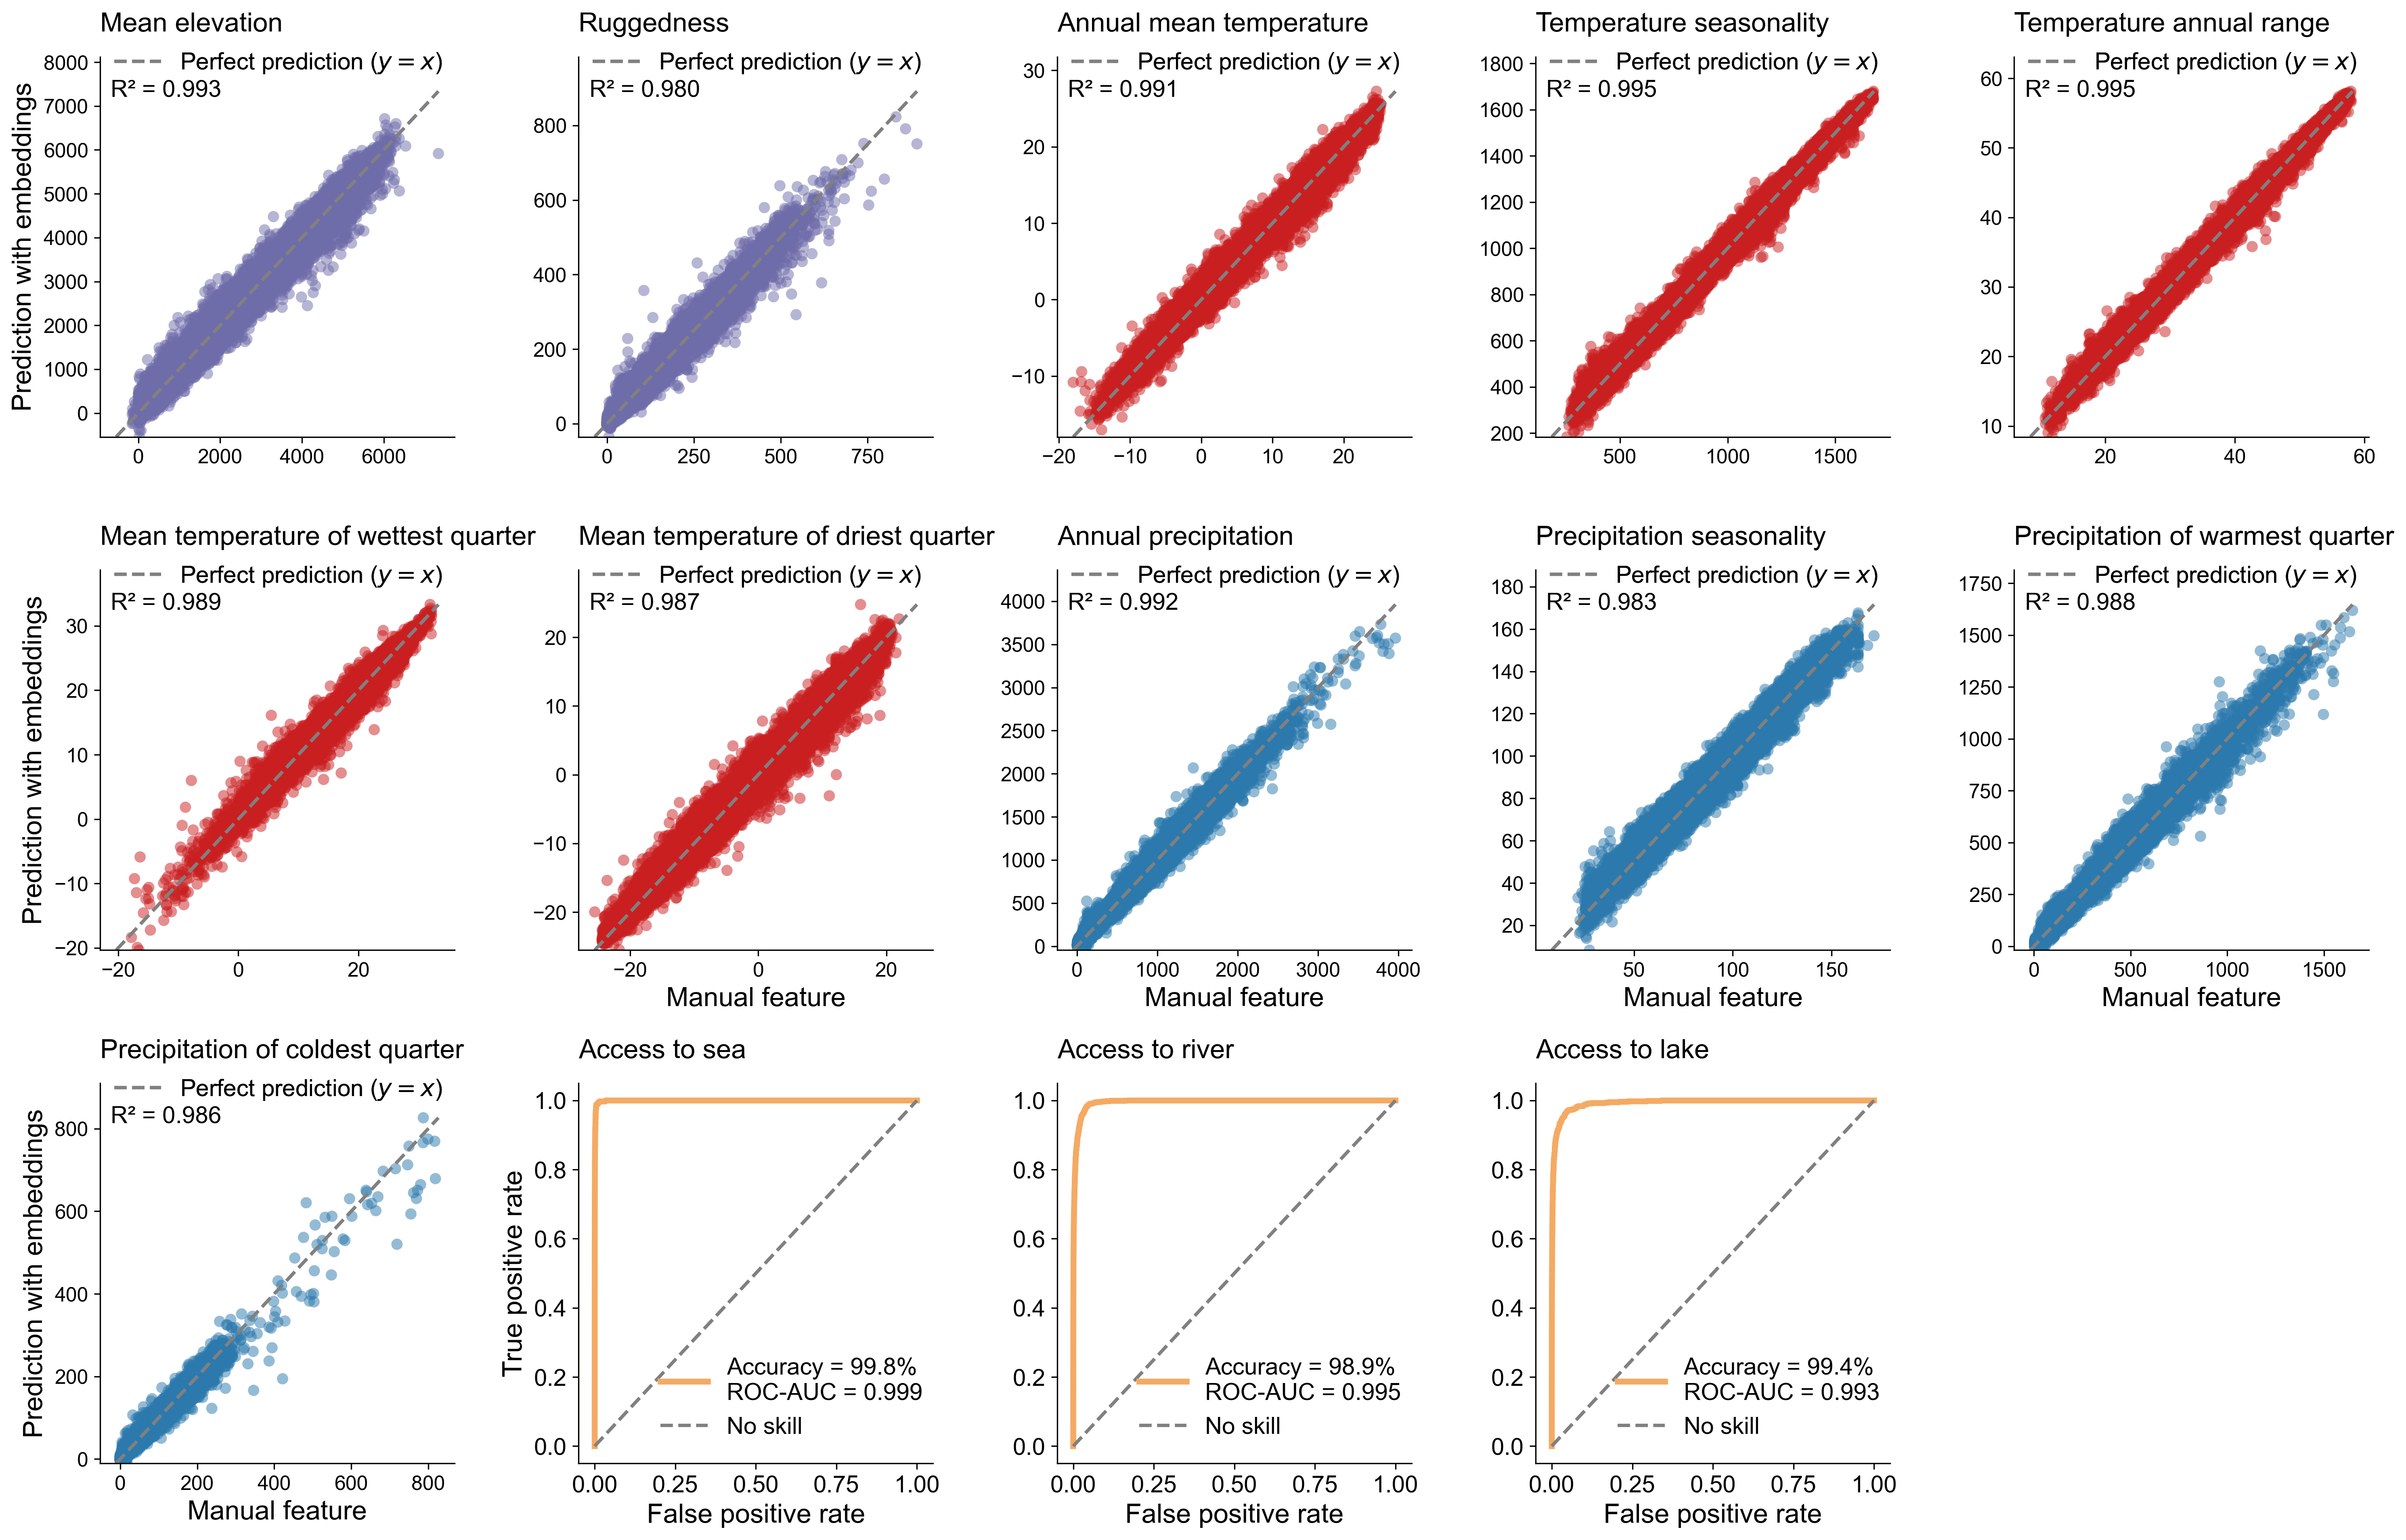

In [ ]:
# Generate a scatter plot manual features and corresponding predictions from embeddings.
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
from sklearn.metrics import r2_score, roc_curve, roc_auc_score, accuracy_score

# Dictionary to map feature codes to human-readable names.
rename_dict = {
    'bio_1': 'Annual mean temperature', 'bio_2': 'Mean diurnal range',
    'bio_3': 'Isothermality', 'bio_4': 'Temperature seasonality',
    'bio_5': 'Max temperature of warmest month', 'bio_6': 'Min temperature of coldest month',
    'bio_7': 'Temperature annual range', 'bio_8': 'Mean temperature of wettest quarter',
    'bio_9': 'Mean temperature of driest quarter', 'bio_10': 'Mean temperature of warmest quarter',
    'bio_11': 'Mean temperature of coldest quarter', 'bio_12': 'Annual precipitation',
    'bio_13': 'Precipitation of wettest month', 'bio_14': 'Precipitation of driest month',
    'bio_15': 'Precipitation seasonality', 'bio_16': 'Precipitation of wettest quarter',
    'bio_17': 'Precipitation of driest quarter', 'bio_18': 'Precipitation of warmest quarter',
    'bio_19': 'Precipitation of coldest quarter', 'mean': 'Mean elevation',
    'std': 'Ruggedness', 'd_sea_dummy': 'Access to sea',
    'd_river_dummy': 'Access to river', 'd_lake1_dummy': 'Access to lake'
}

# Group features by category for consistent coloring and ordering.
terrain_features = ['mean', 'std']
temperature_features = [f'bio_{i}' for i in range(1, 12)]
precipitation_features = [f'bio_{i}' for i in range(12, 20)]
water_features = ['d_sea_dummy', 'd_river_dummy', 'd_lake_dummy']

# Define a professional color scheme for feature categories.
refined_colors = {
    'terrain': '#6F6CAA',      # Muted Blue/Purple
    'temperature': '#CA1F20',  # Muted Red
    'precipitation': '#2B79AD', # Muted Blue/Green
    'water': '#F4AA63'         # Muted Orange
}

# Apply global matplotlib settings for a 'Nature' journal style.
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 16, 'axes.linewidth': 0.8,
    'axes.labelsize': 16, 'xtick.major.width': 0.8,
    'ytick.major.width': 0.8, 'xtick.major.size': 3.5,
    'ytick.major.size': 3.5, 'xtick.labelsize': 14,
    'ytick.labelsize': 14, 'legend.fontsize': 14,
    'figure.dpi': 300, 'pdf.fonttype': 42, 'ps.fonttype': 42
})

# --- Helper and Main Plotting Functions ---

def wrap_title(title, max_length=24):
    """Wraps title text to a new line if it exceeds a maximum length.

    Args:
        title (str): The original title text.
        max_length (int): The maximum character length per line.

    Returns:
        str: The wrapped title text with newline characters.
    """
    words = title.split(' ')
    lines, current_line, current_length = [], [], 0
    for word in words:
        if current_length + len(word) + len(current_line) <= max_length:
            current_line.append(word)
            current_length += len(word)
        else:
            lines.append(' '.join(current_line))
            current_line, current_length = [word], len(word)
    if current_line:
        lines.append(' '.join(current_line))
    return '\n'.join(lines)

def create_combined_plot(models_continuous, attr_list, models_water):
    """Creates a 3x5 grid combining regression and classification performance plots.

    Args:
        models_continuous (dict): Dictionary of trained regression models.
        attr_list (list): List of all continuous attributes.
        models_water (dict): Dictionary of trained classification models.
        water_types (list): List of water-related classification targets.
    
    Returns:
        matplotlib.figure.Figure: The generated figure object.
    """
    fig = plt.figure(figsize=(20, 13))
    rows, cols = 3, 5

    # Order features logically: terrain -> temperature -> precipitation.
    continuous_features = []
    continuous_features.extend([f for f in terrain_features if f in attr_list])
    continuous_features.extend([f for f in temperature_features if f in attr_list])
    continuous_features.extend([f for f in precipitation_features if f in attr_list])

    # Panel A: Regression performance for continuous features.
    for i, feature in enumerate(continuous_features):
        ax = plt.subplot2grid((rows, cols), (i // cols, i % cols), fig=fig)
        try:
            model, X_test, y_test = models_continuous[feature]
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            
            # Determine marker color by feature category.
            if feature in terrain_features: color = refined_colors['terrain']
            elif feature in temperature_features: color = refined_colors['temperature']
            else: color = refined_colors['precipitation']
            
            # Plot scatter of true vs. predicted values.
            ax.scatter(y_test, y_pred, alpha=0.5, edgecolors='none', color=color, s=45)
            
            # Plot diagonal line for reference.
            min_val, max_val = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
            ax.plot([min_val, max_val], [min_val, max_val], color='gray', lw=2.0, linestyle='--')
            
            # Add custom annotations for R² and the perfect prediction line.
            perfect_pred_line = Line2D([0], [0], color='gray', lw=2.0, linestyle='--')
            legend1 = ax.legend([perfect_pred_line], ['Perfect prediction ($y=x$)'], 
                                loc='upper left', bbox_to_anchor=(-0.02, 1.07),
                                fontsize=14, frameon=False)
            ax.add_artist(legend1)
            ax.text(-0.02, 0.94, f'$R^2$ = {r2:.3f}', transform=ax.transAxes, 
                    fontsize=14, va='top', ha='left')
            
        except Exception as e:
            ax.text(0.5, 0.5, f"Error:\n{feature}", transform=ax.transAxes, ha='center', va='center', color='red')
        
        # Set titles and conditional axis labels.
        ax.set_title(rename_dict.get(feature, feature), fontsize=16, loc='left', pad=15)
        if i % cols == 0: ax.set_ylabel('Prediction with embeddings')
        if i // cols == rows - 1 or (i // cols == rows - 2 and i % cols >= 3):
            ax.set_xlabel('Manual feature')

        # Clean up spines and ticks.
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=12)
        y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
        ax.set_ylim(bottom=ax.get_ylim()[0], top=ax.get_ylim()[1] + y_range * 0.1) # Add padding for legend.

    # Panel B: ROC curves for water-related classification tasks.
    for i, water_type in enumerate(water_features):
        ax = plt.subplot2grid((rows, cols), (2, i + 1), fig=fig) # Place in the last row.
        try:
            model, X_test, y_test = models_water[water_type]
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            auc = roc_auc_score(y_test, y_pred_proba)
            
            # Plot ROC curve.
            ax.plot(fpr, tpr, color=refined_colors['water'], lw=3.5, label=f'ROC-AUC = {auc:.3f}')
            ax.plot([0, 1], [0, 1], color='gray', lw=2.0, linestyle='--')
            
            # Configure legend.
            legend = ax.legend(loc="lower right", fontsize=14, frameon=False)
            
        except Exception as e:
            ax.text(0.5, 0.5, f"Error:\n{water_type}", transform=ax.transAxes, ha='center', va='center', color='red')

        # Set titles and conditional axis labels.
        ax.set_title(rename_dict.get(water_type, water_type), fontsize=16, loc='left', pad=15)
        ax.set_xlabel('False positive rate')
        if i == 0: ax.set_ylabel('True positive rate')
        
        # Clean up spines.
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.35, hspace=0.5)
    
    return fig


# Check if required model dictionaries are loaded in the environment.
if 'models_continuous' in locals() and 'attr_list' in locals() and 'models_water' in locals():
    try:
        # Generate the plot.
        fig = create_combined_plot(models_continuous, attr_list, models_water)
        
        output_dir = "/path/to/your/output/"
        base_filename = "prediction_of_manual_features_using_embeddings"
        
        # Save figure in multiple formats.
        plt.savefig(f"{output_dir}{base_filename}.png", dpi=300, bbox_inches='tight')
        plt.savefig(f"{output_dir}{base_filename}.pdf", bbox_inches='tight')
        
        plt.show()
        
    except Exception as e:
        print(f"An error occurred while creating the plot: {e}")
else:
    print("This script requires 'models_continuous', 'attr_list', and 'models_water' variables.")
    print("Please ensure they are defined in your notebook's environment before running this cell.")